# IEEE NASC 2024 - Predict Data Center Missing Resource Usage Data

**Author**: Aryamaan Dhomne

Welcome to the Data Center Missing Resource Usage Imputation Challenge!

In this competition, you will work with resource usage data from a supercomputer. The data consists of various metrics like CPU usage, memory consumption, GPU activity, and data transfer rates. However, some data values are missing.

Your objective is to impute missing values at a consistent two-minute interval using different techniques. By resampling the data and applying imputation methods, you'll create a complete time series ready for further analysis.

In this notebook, we explore an example solution for working with this data. We use an XGBoost-based autoregressive model and cover some basic data exploration and feature engineering techniques.

# Setup/Imports

In [1]:
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_missing_data.csv
!wget https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/grading_jobs_misisng_data.csv

--2024-10-21 22:27:47--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_training_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 52.217.167.185, 3.5.30.241, 52.217.124.137, ...
Connecting to fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)|52.217.167.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12156758 (12M) [text/csv]
Saving to: ‘participant_training_jobs_full_data.csv’

participant_trainin 100%[===================>]  11.59M  16.0MB/s    in 0.7s    

2024-10-21 22:27:48 (16.0 MB/s) - ‘participant_training_jobs_full_data.csv’ saved [12156758/12156758]

--2024-10-21 22:27:48--  https://fresco-host-data-challenege.s3.amazonaws.com/participant-data/participant_test_jobs_full_data.csv
Resolving fresco-host-data-challenege.s3.amazonaws.com (fresco-host-data-challenege.s3.amazonaws.com)... 3.5.3.11, 3.5.29.

In [2]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.4 MB/s eta 0:00:0

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from darts import TimeSeries

# Preprocess Data
In this section, we pivot the dataframe to create a wider table, where metrics are aligned by timestamp

We also create two new columns:
- `relative_index`: index within each job to each record
- `time_since_job_start` the number of seconds that have elapsed since the job started

In [4]:
train_df = pd.read_csv("./participant_training_jobs_full_data.csv")
test_df = pd.read_csv("./participant_test_jobs_full_data.csv")
test_missing_df = pd.read_csv("./participant_test_jobs_missing_data.csv")
grading_df = pd.read_csv("./grading_jobs_misisng_data.csv")

In [5]:
event_cols = ['block', 'cpuuser', 'gpu_usage', 'memused', 'memused_minus_diskcache', 'nfs']
groupby_cols = ['job_id', 'host']

In [6]:
dfs = [train_df, test_df, test_missing_df, grading_df]
for df in dfs:
  df['relative_index'] = df.groupby(groupby_cols).cumcount()

In [7]:
for df in dfs:
  df['time_since_job_start'] = 0
  for (job_id, host), group in df.groupby(groupby_cols):
    group['time_since_job_start'] = group.ts_delta * group.relative_index
    df.loc[group.index, 'time_since_job_start'] = group.time_since_job_start
  df.time_since_job_start = df.time_since_job_start.astype(int)

# Initial Analysis
Let's find out if our usage data is autocorrelated. This will help us determine if autoregressive models would be a good fit, and what lag value we should use.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


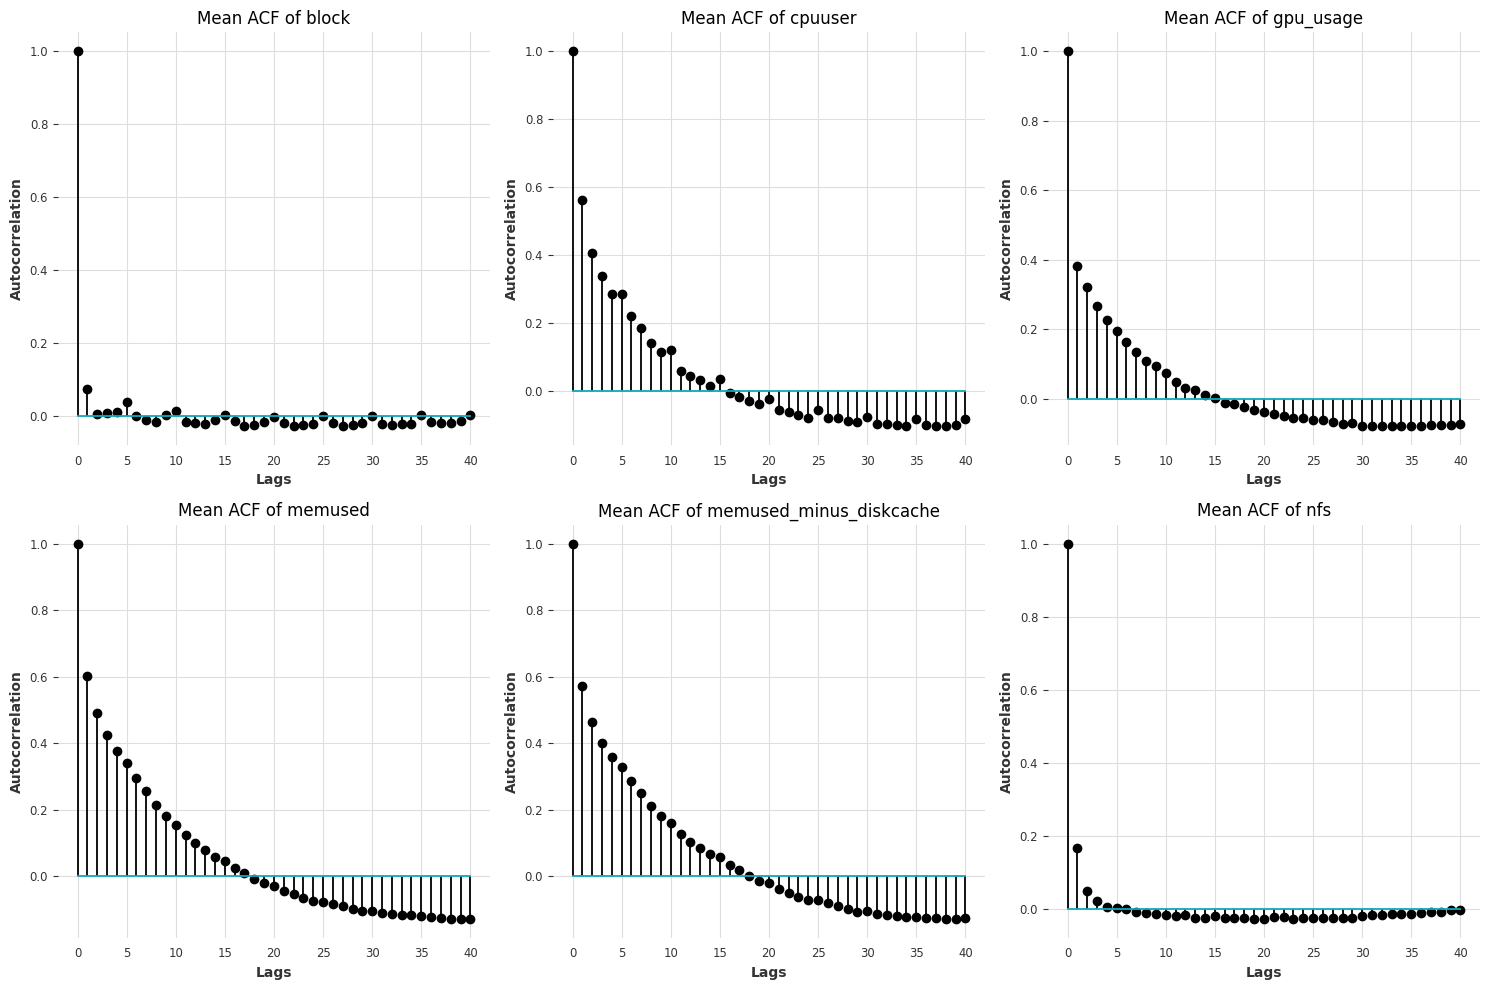

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

# List of columns you want to evaluate across all job sequences
max_lag = 40  # Set the maximum number of lags for autocorrelation

# Set up the grid for the plots: 2 rows and 3 columns (for 6 columns to evaluate)
n_rows = 2
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

for idx, col in enumerate(event_cols):
  all_acfs = []  # To store autocorrelations for each job

  # Loop through each job and calculate the autocorrelation
  for job in train_df.job_id.unique():
    job_seq = train_df[train_df.job_id == job][col].dropna()

    if not job_seq.empty:
      acf_values = acf(job_seq, nlags=max_lag)
      all_acfs.append(acf_values)

  # Find the maximum length of autocorrelation returned
  max_acf_length = max(len(acf_values) for acf_values in all_acfs)

  # Pad all autocorrelations to match the maximum length
  padded_acfs = [np.pad(acf_values, (0, max_acf_length - len(acf_values)), constant_values=np.nan) for acf_values in all_acfs]

  # Convert the list of padded ACFs into a NumPy array for easy mean calculation
  all_acfs = np.array(padded_acfs)

  # Compute the mean autocorrelation across all jobs, ignoring NaNs
  mean_acf = np.nanmean(all_acfs, axis=0)

  # Plot the mean autocorrelation in the corresponding subplot
  axes[idx].stem(range(len(mean_acf)), mean_acf)
  axes[idx].set_title(f"Mean ACF of {col}")
  axes[idx].set_xlabel("Lags")
  axes[idx].set_ylabel("Autocorrelation")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Training Imputation models
Based on the plots above, it looks like most of our usage metrics are autocorrelated. Let's choose a lag value of 5 to train our model and use the XGBModel from [darts](https://unit8co.github.io/darts/)

In [9]:
from darts.models import LightGBMModel
from darts import TimeSeries

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [10]:
# Create TimeSeries objects for darts models
# Use the time_since_job_start as the time index for each time series
train_ts_list = []
train_df_grouped = train_df.groupby(groupby_cols)
for (job_id, host), group_df in train_df_grouped:
    ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
    # converting to a float32 since MPS (Apple ARM acceleration) does not support float64
    # you may not need to do this!
    train_ts_list.append(ts.astype(np.float32))

In [11]:
from darts.models import RNNModel, LightGBMModel
from darts.models.forecasting.lgbm import LightGBMModel
from sklearn.metrics import mean_squared_error
import torch

lstm_model = RNNModel(
    model='LSTM',
    input_chunk_length=5,    # Sequence length of past data
    output_chunk_length=1,    # Predict next time step
    n_epochs=10,             # Number of training epochs
    random_state=42
)

lstm_model.fit(train_ts_list)

# Step 2: Generate LSTM outputs as features for the LightGBM model
lstm_features = []
for ts in train_ts_list:
    lstm_pred = lstm_model.historical_forecasts(ts, retrain=False)
    lstm_features.append(lstm_pred.pd_dataframe())  # Collect predictions as features

# Step 3: Combine LSTM features with the original feature set for LightGBM
lstm_feature_df = pd.concat(lstm_features)
# X_train_combined = pd.concat([train_df, lstm_feature_df], axis=1)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.3 K  | train
6 | V               | Linear           | 156    | train
-------------------------------------------------------------
3.5 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_R

In [12]:
train_df = train_df.reset_index(drop=True)
lstm_feature_df = lstm_feature_df.reset_index(drop=True)

# # Now you can safely concatenate
X_train_combined = pd.concat([train_df, lstm_feature_df], axis=1)

X_ts = []
X_df_grouped = X_train_combined.groupby(groupby_cols)
for (job_id, host), group_df in train_df_grouped:
    ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
    X_ts.append(ts.astype(np.float32))


In [13]:
# Assuming 'time_since_job_start' is your time column and 'target_variable' is the column you want to predict

# Now you can fit the model with the TimeSeries object
model = LightGBMModel(lags=5)
model.fit(X_ts)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 87992, number of used features: 30
[LightGBM] [Info] Start training from score 0.000021
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7566
[LightGBM] [Info] Number of data points in the train set: 87992, number of used features: 30
[LightGBM] [Info] Start training from score 12.640378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

LightGBMModel(lags=5, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, categorical_past_covariates=None, categorical_future_covariates=None, categorical_static_covariates=None)

# Model Evaluation

Now that we've trained our model, let's evaluate it on the test dataset so we know if our model works!

In [14]:
# we're using a dict here so that we can get predictions for specific job_id/host combinations
# this will be useful for plotting later on
test_ts_list = {}
test_df_grouped = test_df.groupby(groupby_cols)
for (job_id, host), group_df in test_df_grouped:
  ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
  test_ts_list[(job_id, host)] = ts.astype(np.float32)

In [43]:
imputed_df = test_missing_df.copy()
# update imputed_df index so it's easier to set values
imputed_df = imputed_df.set_index([*groupby_cols, 'timestamp'])
for (job_id, host), ts in list(test_ts_list.items()):
  # Use the TS model to predict our event columns "in the past"
  # note that our first output will be at the 5th record, since we use a lag value of 5
  pred = model.historical_forecasts(ts, retrain=False).pd_dataframe()
  missing_job_df = test_missing_df[(test_missing_df.job_id == job_id) & (test_missing_df.host == host)].set_index('time_since_job_start')
  nan_indexes = missing_job_df[missing_job_df.isna().any(axis=1)].index
  # filter the nan indexes since we don't have data for the first 5 records (t<600s)
  nan_indexes = nan_indexes[nan_indexes > 600]
  missing_job_df.loc[nan_indexes, event_cols] = pred.loc[nan_indexes, event_cols]
  # fill the first 5 records with the average of the rest of the data (there's probably room for imporovement here!)
  missing_job_df[event_cols] = missing_job_df[event_cols].fillna(missing_job_df[event_cols].mean())
  missing_job_df = missing_job_df.reset_index().set_index([*groupby_cols, 'timestamp'])
  imputed_df.loc[missing_job_df.index] = missing_job_df

Let's visualize a random job_id and host combination so we can see how accurate our imputaion is.

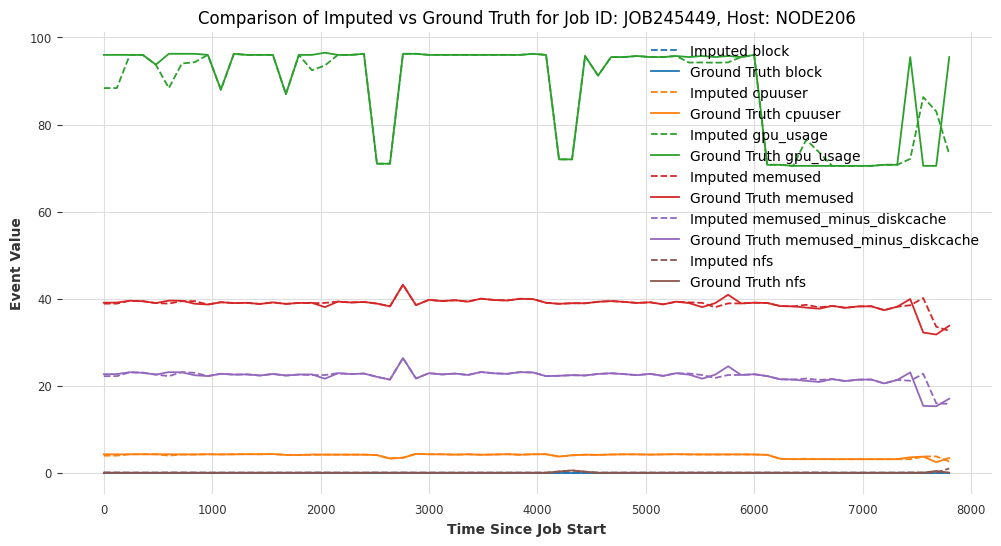

In [16]:
import random
import itertools

# sample a random job_id, host combo to look at the data
(job_id, host), ts = random.choice(list(test_ts_list.items()))
sample_imputed = imputed_df.loc[(job_id, host)].set_index('time_since_job_start')
sample_ground_truth = test_df.set_index(['job_id', 'host']).loc[(job_id, host)].set_index('time_since_job_start')

colors = itertools.cycle(plt.cm.tab10.colors)

plt.figure(figsize=(12, 6))

# Plot each event column from the imputed and ground truth data with the same color
for col in event_cols:
  color = next(colors)
  plt.plot(sample_imputed.index, sample_imputed[col], label=f'Imputed {col}', linestyle='--', color=color)
  plt.plot(sample_ground_truth.index, sample_ground_truth[col], label=f'Ground Truth {col}', linestyle='-', color=color)

# Add title and labels
plt.title(f'Comparison of Imputed vs Ground Truth for Job ID: {job_id}, Host: {host}')
plt.xlabel('Time Since Job Start')
plt.ylabel('Event Value')

plt.legend()

Looks pretty good! Let's calculate some objective metrics now.

In [45]:
import math
from sklearn.metrics import mean_squared_error

# compare the XGB model against a naive mean fill for the entire dataset
imputed_df = imputed_df.reset_index().sort_values([*groupby_cols, 'timestamp']).reset_index(drop=True)
# reset the index of test_df and drop the 'level_0' column
test_df = test_df.reset_index().sort_values([*groupby_cols, 'timestamp']).reset_index(drop=True)
#This will drop the existing 'level_0' if it exists
test_missing_df = test_missing_df.sort_values([*groupby_cols]).reset_index(drop=True)
naive_imputed_df = test_missing_df.copy()
naive_imputed_df[event_cols] = test_missing_df[event_cols].fillna(test_missing_df[event_cols].mean())

nan_idxs = test_missing_df[test_missing_df[event_cols].isna().any(axis=1)].index

print("XGB model RMSE: ", math.sqrt(mean_squared_error(imputed_df.loc[nan_idxs, event_cols], test_df.loc[nan_idxs, event_cols])))
print("Naive mean RMSE: ", math.sqrt(mean_squared_error(naive_imputed_df.loc[nan_idxs, event_cols], test_df.loc[nan_idxs, event_cols])))

XGB model RMSE:  5.192009325998298
Naive mean RMSE:  30.724166301064518


# Grading dataset prediction

Nice! It looks like our XGB performs significantly better than the Naive mean fill. Now let's run our model on the grading dataset and submit our prediction.

In [18]:
grade_ts_list = {}
grade_df_grouped = grading_df.groupby(groupby_cols)
for (job_id, host), group_df in grade_df_grouped:
  ts = TimeSeries.from_dataframe(group_df, 'time_since_job_start', value_cols=event_cols)
  grade_ts_list[(job_id, host)] = ts.astype(np.float32)

In [19]:
imputed_grade_df = grading_df.copy()
imputed_grade_df = imputed_grade_df.set_index([*groupby_cols, 'timestamp'])
for (job_id, host), ts in list(grade_ts_list.items()):
  pred = model.historical_forecasts(ts, retrain=False).pd_dataframe()
  missing_job_df = grading_df[(grading_df.job_id == job_id) & (grading_df.host == host)].set_index('time_since_job_start')
  nan_indexes = missing_job_df[missing_job_df.isna().any(axis=1)].index
  nan_indexes = nan_indexes[nan_indexes > 600]
  missing_job_df.loc[nan_indexes, event_cols] = pred.loc[nan_indexes, event_cols]
  missing_job_df[event_cols] = missing_job_df[event_cols].fillna(missing_job_df[event_cols].mean())
  missing_job_df = missing_job_df.reset_index().set_index([*groupby_cols, 'timestamp'])
  imputed_grade_df.loc[missing_job_df.index] = missing_job_df

In [20]:
imputed_grade_df.reset_index().to_csv("prediction.csv")